In [ ]:
import numpy as np

from matplotlib import pyplot as plt

import torch

from torch.nn import functional as F

In [ ]:
total_alphas = 200

In [ ]:
def relu(x):
    return (x > 0) * x

def rot_mat(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

def correct_direction(u):

    if u[np.argmax(np.abs(u))] < 0:
        return -u
    else:
        return u

def normalize_and_transform(act, ctx):
    dims = act.shape[1]
 
    act = act / ((np.mean(act**2) ** (1 / 2)) * (dims ** (1 / 4)))
    ctx = ctx / ((np.mean(ctx**2) ** (1 / 2)) * (dims ** (1 / 4)))

    act = torch.tensor(act)
    ctx = torch.tensor(ctx)

    return act, ctx

In [ ]:
def generate_data(alpha, seed=1):
    np.random.seed(seed)

    # proportion of sample for Group 1
    beta = 0.5
    total = 1000

    num_group_1_samples = int(total * beta )
    num_group_2_samples = total - num_group_1_samples


    base = 10
    delta = 0.2 * base

    # print(f"base={base}; delta={delta}")



    cov1 = np.diag([base, 1])
    mu1  = [base + base ** 0.5, 0] 

    cov2 = np.diag([base + delta, 1])
    mu2  = [base + base ** 0.5, 0] 



    # cov1 = np.diag([5, 1])
    # mu1  = [cov1[0, 0] + cov1[0, 0] ** 0.5, 0] 

    # cov2 = np.diag([5 + delta, 1])
    # mu2  = [cov2[0, 0] + cov2[0, 0] ** 0.5, 0] 


    theta_adj = np.pi/4 * alpha
    theta1 = -np.pi/4  + theta_adj
    theta2 = -np.pi/4 - theta_adj

    x1 = np.random.multivariate_normal(mean=mu1, cov=cov1, size=num_group_1_samples)
    x1 = x1 @ rot_mat(theta1) 
    x1 = relu(x1)


    x2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=num_group_2_samples)
    x2 = x2 @ rot_mat(theta2)  
    x2 = relu(x2)



    _, eigvecs_1 = np.linalg.eigh(x1.T @ x1)
    w1 = correct_direction(eigvecs_1[:, -1])

    _, eigvecs_2 = np.linalg.eigh(x2.T @ x2)
    w2 = correct_direction(eigvecs_2[:, -1])


    X = np.vstack([x1, x2])
    # model response has label==1; and the other have label==0
    labels = [1] * num_group_1_samples+ [0] * num_group_2_samples
    labels = np.array(labels)
    C = np.zeros_like(X)


    w = w1
    C[:, 0] = w[0]
    C[:, 1] = w[1]

    return X, labels, C, w, w1, w2

generate_data(alpha=0.25);

In [ ]:
def arrow_with_annotation(direction, text, color, lw=1, ls="-", scaling=1, starting_at=(0, 0), text_end=True):

    direction = direction *  scaling / (np.linalg.norm(direction))
    dest = np.array(direction) + np.array(starting_at)

    plt.annotate(s='', xy=starting_at, xytext=dest, arrowprops=dict(arrowstyle='<-', color=color, ls=ls, lw=lw))

    text_loc = dest if text_end else starting_at
    plt.text(
        text_loc[0], text_loc[1],
        text,
        fontsize="large",
        verticalalignment="center"
    )

In [ ]:
from numpy.lib.arraysetops import isin
def softmax_p(x: torch.Tensor, ord: int=2, dim=0) -> torch.Tensor:
    """Perform softmax order `ord` along `dim`

    Returns:
        torch.Tensor:
    """

    assert ord >= 1

    return (x**ord).mean(dim=dim) ** (1 / ord)


def softmin_p(x: torch.Tensor, ord: int=2, dim=0) -> torch.Tensor:
    """Perform softmin order `ord` along `dim`

    Returns:
        torch.Tensor:
    """

    assert ord >= 1

    return ((x ** (1 / ord)).mean(dim=dim)) ** (ord)

def pca_obj(X, C, u):
    error = np.linalg.norm(X - np.outer((X @ u), u), axis=1) ** 2

    val  = np.mean(error)

    # make it a maximization problem
    return  - val

def prca_obj(X, C, u):
    rel = (X @ u) * (C @ u)

    return np.mean(rel)


def dsa_obj(X, C, u):
    """_summary_

    remark: This loss is similar to Q. Le's paper.
    remark: Check this again.

    Args:
        activation (torch.Tensor): _description_
        context (torch.Tensor): we do NOT use context here.
            We keep it to make the interface compatible with the IRCA objective.

    Returns:
        torch.Tensor: _description_
    """

    # shape: [n, ng]

    activation = torch.from_numpy(X @ u).reshape((X.shape[0], 1, 1))

    n, ns, _ = activation.shape

    # here, we use only the activation,
    magnitude = activation * activation

    component_magnitude = magnitude.sum(dim=2)
    assert component_magnitude.shape == (n, ns)

    # Step 1: Perform soft-max pooling over data (n)
    # e.g., smax_n
    component_magnitude = softmax_p(component_magnitude, ord=2, dim=0)

    assert component_magnitude.shape == (ns,)

    # Step 2: Perform soft-min pooling over K subspaces
    # e.g., smin_K
    obj = softmin_p(component_magnitude, ord=2, dim=0)

    assert len(obj.shape) == 0

    return obj

def drsa_obj(X, C, u):
    """_summary_

    This implements the IRCA objective.

    Args:
        activation (torch.Tensor): _description_
        context (torch.Tensor): _description_

    Returns:
        torch.Tensor: _description_
    """

    activation = torch.from_numpy(X @ u).reshape((X.shape[0], 1, 1))
    context = torch.from_numpy(C @ u).reshape((X.shape[0], 1, 1))

    assert (
        len(activation.shape) == len(context.shape) == 3
        and activation.shape == context.shape
    )

    relevance = activation * context

    # shape: [n, ng]
    n, ns, _ = relevance.shape

    component_relevance = relevance.sum(dim=2)

    component_relevance = F.relu(component_relevance)

    assert component_relevance.shape == (n, ns)

    # Step 1: Perform soft-max pooling over data (n)
    # e.g., smax_n
    component_relevance = softmax_p(component_relevance, ord=2, dim=0)

    assert component_relevance.shape == (ns,)

    # Step 2: Perform soft-min pooling over K subspaces
    # e.g., smin_K
    obj = softmin_p(component_relevance, ord=2, dim=0)

    assert len(obj.shape) == 0

    return obj


def get_arr_obj(obj_func, arr_theta, X, C):

    arr_obj = []

    for theta in arr_theta:
        u = np.array([np.cos(theta), np.sin(theta)])
        arr_obj.append(
            obj_func(X, C, u)
        )
    arr_obj = np.array(arr_obj)

    if obj_func ==  pca_obj or obj_func == prca_obj:

        if obj_func == pca_obj:
            _, eigvecs = np.linalg.eigh(X.T @ X)
            
        
        elif obj_func == prca_obj:
            _, eigvecs = np.linalg.eigh(X.T @ C + C.T @ X)
            
        e = eigvecs[:, -1]
        e = correct_direction(e)
        theta = np.arctan2(e[1], e[0])

    else:
        theta = arr_theta[np.argmax(arr_obj)]

    w = np.array([np.cos(theta), np.sin(theta)])

    # min-max normalization
    # normalized_val = (normalized_val - np.min(normalized_val)) / (np.max(normalized_val) - np.min(normalized_val))

    if obj_func == pca_obj:
        # smallest now becomes zero
        adjust_obj = arr_obj - np.min(arr_obj)

        normalized_val = adjust_obj / np.max(adjust_obj)
        
    else:
        normalized_val = (arr_obj) /  np.max(arr_obj) 

    
    return dict(
        w=w,
        theta=theta,
        normalized_obj_vals=normalized_val,
        raw_optimal_obj=arr_obj[np.argmax(arr_obj)],
        raw_obj_vals=arr_obj,
    )

# _ = get_arr_obj(drsa_obj, arr_theta, w_model)

In [ ]:
def sanity_check():

    alpha = 0.75

    for alpha in [0.25, 0.75, 1]:
        for seed in range(5):
                
            seed = 1

            X, labels, C, w_model, w1, w2 = generate_data(alpha=alpha, seed=seed)

            u = np.array([0.5, 0.5])

            u = u / np.linalg.norm(u)

            ref_drsa_val = drsa_obj(X, C, u)
            ref_dsa_val  = dsa_obj(X, C, u)

            
            actual_drsa_v =  np.mean(((X @ u) * (C @ u))**2) ** 0.5
            actual_dsa_v =  np.mean(((X @ u) * (X @ u))**2) ** 0.5

            
            np.testing.assert_allclose(actual_drsa_v, ref_drsa_val)
            np.testing.assert_allclose(actual_dsa_v, ref_dsa_val)

    print("Everything correct!")

sanity_check()

Everything correct!


In [ ]:
def sol_color(name):

    if name in ["PCA", "DSA"]:
        return "b"
    elif name in ["PRCA", "DRSA"]:
        return "tab:red"
    elif "Principal Direction" in name:
        return "k"

def sol_ls(name):

    if name in ["PCA", "PRCA"]:
        return "--"
    elif name in ["DSA", "DRSA"]:
        return "-"

def sol_marker(name):

    if name in ["PCA", "PRCA"]:
        return "o"
    elif name in ["DSA", "DRSA"]:
        return "^"

In [ ]:
def suffix(name):
    if "DRSA" in name or "PRCA" in name:
        return f"{name} (Ours)"
    else:
        return name

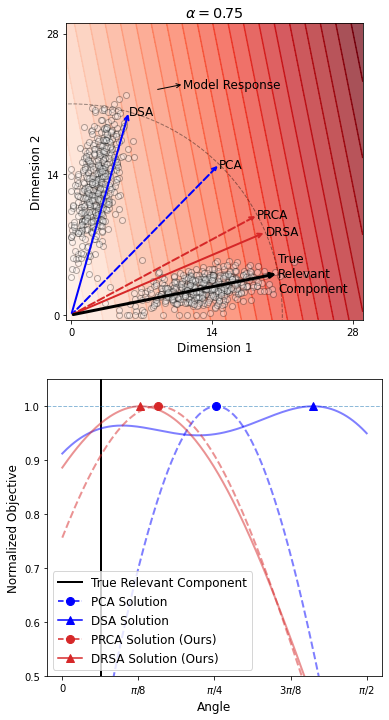

In [ ]:
def plot_solution(arr_alphas, seed=1, alpha_for_legend=0.75):
    ncols = len(arr_alphas)
    nrows = 2

    arr_theta = np.linspace(0, np.pi/2, endpoint=True, num=total_alphas)

    plt.figure(figsize=(6*ncols, 6*nrows))

    for aix, alpha in enumerate(arr_alphas):

        show_legend = alpha == alpha_for_legend
            
        X, labels, C, w_model, w1, w2 = generate_data(alpha=alpha, seed=seed)

        max_val = np.round(np.max(X)) + 5
        if max_val % 2 != 0:
            max_val += 1

        upperbound = max_val + 1
        min_val = -0.5
        _range = np.linspace(min_val, upperbound)
        xx, yy = np.meshgrid(_range, _range)
        xcontour = np.stack([xx.reshape(-1), yy.reshape(-1)]).T

        cost = (xcontour @ w_model).reshape(xx.shape)

        
        sol_pca = get_arr_obj(pca_obj, arr_theta, X, C)
        sol_prca = get_arr_obj(prca_obj, arr_theta, X, C)
        sol_dsa = get_arr_obj(dsa_obj, arr_theta, X, C)
        sol_drsa = get_arr_obj(drsa_obj, arr_theta, X, C)

        arr_solutions = [
            ("PCA", sol_pca),
            ("DSA", sol_dsa),
            ("PRCA", sol_prca),
            ("DRSA", sol_drsa)
        ]


        plt.subplot(nrows, ncols, aix +1)

        plt.title(f"$\\alpha={alpha}$", fontsize="x-large")
        plt.contourf(xx, yy, cost, cmap="Reds", levels=30, alpha=0.7)
        plt.contour(xx, yy, cost, cmap="Reds", levels=30, alpha=1, zorder=0)

        for label in [1, 0]:
            _s = "$\mathcal{D}_1$" if label == 1 else "$\mathcal{D}_2$"
            _c = "Model Response" if label == 1 else "Larger Variance"
            _s = f"{_s} ({_c})"
            plt.scatter(
                X[labels==label, 0],
                X[labels==label, 1],
                marker="o",
                alpha=0.3,
                color="k",
                facecolor="w",
                label=f"Dist. {_s}"
            )

        arrow_with_annotation(
            w_model, "Model Response" if show_legend else "", "k", scaling=0.1*max_val, lw=1,
            starting_at=(max_val * 0.3, max_val * 0.8),
            text_end=True
        )


        for name, sol in arr_solutions:
            arrow_with_annotation(sol["w"], name if show_legend else "", color=sol_color(name), ls=sol_ls(name), scaling=0.75*max_val, lw=2)

        arrow_with_annotation(
            w_model, "True\nRelevant\nComponent" if show_legend else "", "k", scaling=0.75*max_val, lw=3,
            # starting_at=(max_val * 0.3, max_val * 0.8),
            text_end=True
        )


        plt.xlim([min_val, upperbound]); plt.ylim([min_val, upperbound])

        if aix == 0:
            plt.ylabel("Dimension 2", fontsize="large")
        
        plt.xlabel("Dimension 1", fontsize="large");  

        plt.xticks([0, max_val / 2, max_val])
        plt.yticks([0, max_val / 2, max_val])


        # if show_legend:
        #     plt.legend(fontsize="large")

        circle = plt.Circle( (0.0, 0.0), max_val * 0.75, fill=False, ls="--", alpha=0.4)
        ax = plt.gca()
        ax.add_patch(circle)
        ax.set_aspect("equal")

        #####
        plt.subplot(nrows, ncols, ncols + aix +1)
        plt.title(" ", fontsize="x-large")
        plt.axvline(np.arctan2(w1[1], w1[0]), ls="-", lw=2, color="k", label="True Relevant Component")
        # plt.axvline(np.arctan2(w2[1], w2[0]), ls="--", lw=1, color="k", label="Principal Direction of $\mathcal{D}_2$")
        plt.ylim([0.5, 1.05])
        plt.axhline(1, ls="--", lw=1, alpha=0.5)
        for name, sol in arr_solutions:
            plt.plot(
                sol["theta"],
                np.max(sol["normalized_obj_vals"]),
                marker=sol_marker(name),
                color=sol_color(name),
                label=suffix(f"{name} Solution"),
                ls=sol_ls(name),
                markersize=8
            )
            plt.plot(
                arr_theta,
                sol["normalized_obj_vals"],
                color=sol_color(name), ls=sol_ls(name),
                lw=2,
                alpha=0.5
            )

        plt.xticks([0, np.pi/8, np.pi / 4, 3*np.pi / 8, np.pi/2], ['0',  '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$'])

        plt.xlabel("Angle", fontsize="large")

        if aix == 0:
            plt.ylabel("Normalized Objective", fontsize="large")
        else:
            plt.yticks([])
        if show_legend:
            # plt.legend(bbox_to_anchor=(1,1), loc="upper left")
            plt.legend(fontsize="large")
            


plot_solution([0.75])
plt.savefig("toy-example.png", dpi=150, bbox_inches='tight')

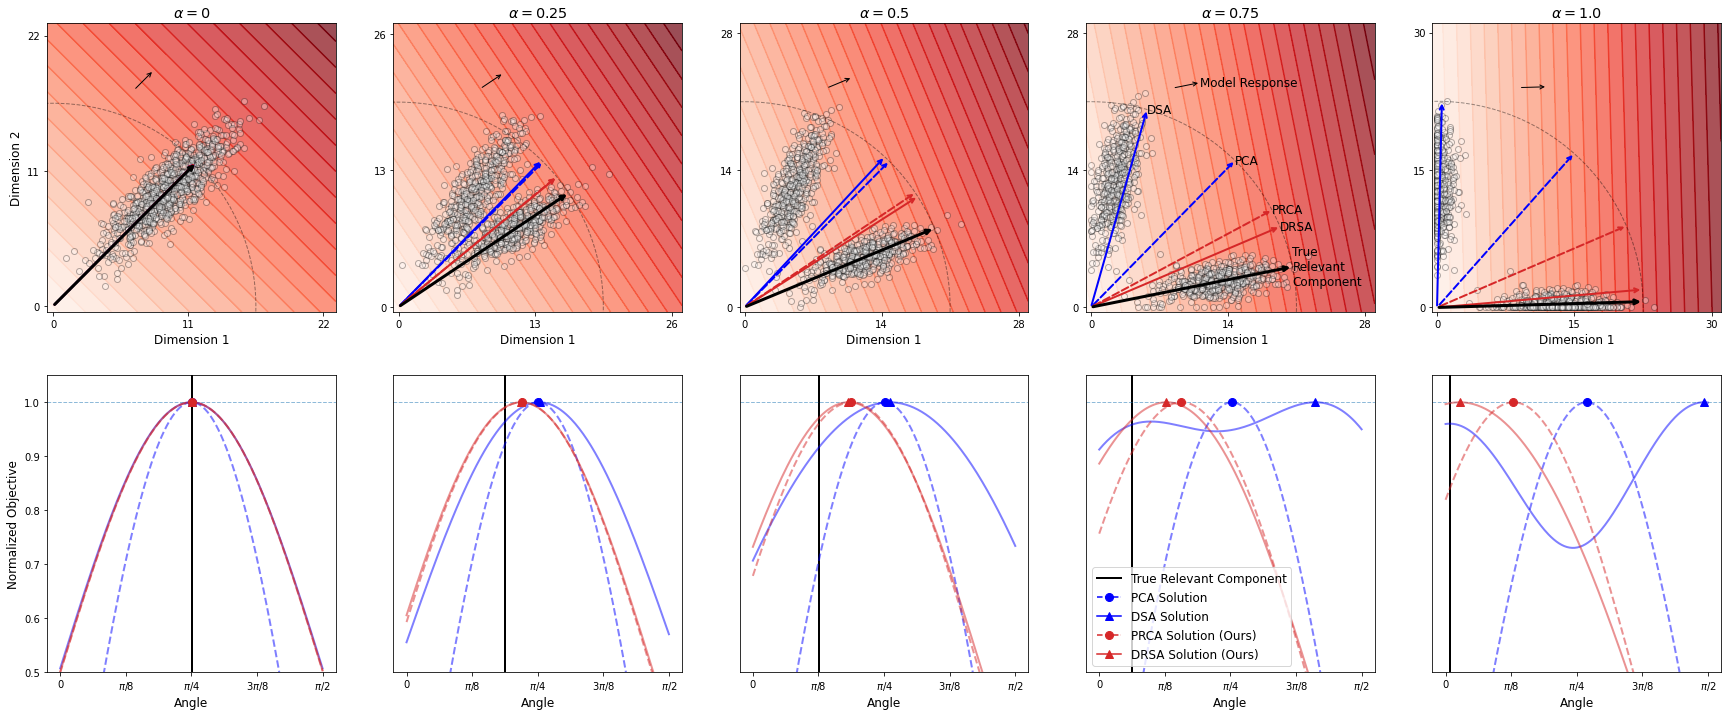

In [ ]:
plot_solution([0, 0.25, 0.5, 0.75, 1.0])
plt.savefig("toy-example-varying-alphas.png", dpi=150, bbox_inches='tight')

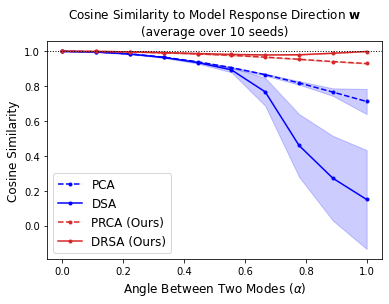

In [ ]:
def iter(arr_alphas):
    arr_theta = np.linspace(0, np.pi/2, endpoint=True, num=total_alphas)
    arr_seeds = list(range(1, 10+1))

    approaches = [
        ("PCA",  pca_obj),
        ("DSA", dsa_obj),
        ("PRCA",  prca_obj),
        ("DRSA", drsa_obj)
    ]
    stats = np.zeros((len(approaches) +1, len(arr_seeds), len(arr_alphas)))
    for aix, alpha in enumerate(arr_alphas):

        for six, seed in enumerate(arr_seeds):

            X, labels, C, w_model, w1, w2 = generate_data(seed=seed, alpha=alpha)

            for lix, (label, obj) in enumerate(approaches):
                sol = get_arr_obj(obj, arr_theta, X, C)
                stats[lix, six, aix]  = sol["w"].dot(w_model)

            stats[-1, six, aix] = w2.dot(w_model)
    
    for i in range(len(approaches) ):
        name = approaches[i][0] if i <= 3 else "Principal Direction of $\mathcal{D}_2$"

        _stat = stats[i]
        mean = _stat.mean(axis=0)
        std = _stat.std(axis=0)
        plt.plot(arr_alphas, _stat.mean(axis=0), label=suffix(name), ls=sol_ls(name), marker=".", color=sol_color(name))

        plt.fill_between(arr_alphas, mean - std, mean + std, alpha=0.2, color=sol_color(name))


    plt.title("\n".join([
        "Cosine Similarity to Model Response Direction $\mathbf{w}$",
        f"(average over {len(arr_seeds)} seeds)"
    ]), fontsize="large")
    plt.ylabel("Cosine Similarity", fontsize="large")

    plt.xlabel("Angle Between Two Modes ($\\alpha$)", fontsize="large")
    plt.axhline(1, ls=":", color="k", lw=1)


    plt.legend(fontsize="large")

iter(np.linspace(0, 1.0, endpoint=True, num=10))

plt.savefig("toy-example-varying-alpha-and-seed.png", dpi=150)